# Presentación de la empresa, organización o problema específico.

Desde hace varios años vemos como el internet a revolucionado todos los ámbitos de nuestra vida, todo lo queremos hacer por internet. Desde investigar sobre algo que nos pusieron en el trabajo o escuela, averiguar a qué horas cierran nuestra tienda favorita, querer pagar alguna factura, hasta comprar nuestros artículos favoritos desde la comodidad de nuestro hogar. Y sí, las compras por internet (E-commerce) han revolucionado el mercado. Hoy en día hay miles y miles de tiendas y empresas que ofrecen millones de productos. Ahora bien, ¿cuáles fatores se tienen en cuenta a la hora de realizar una compra? ¿Cuáles productos, categorías son las más vendidas? ¿Dónde se vende más? ¿Cuáles son las categorías y productos con las mejores y peores calificaciones? ¿Qué factores debe tener cuenta una empresa para asegurarse de que sus productos sean vendidos? ¿Qué afecta la calificación que se le da un producto? ¿Qué factores externos contribuyen a que un tipo de producto se venda más que otro? 

Para poder responder estas preguntas hemos escogido una empresa brasilera, Olist, que conecta pequeñas empresas y sirve como punto de contacto para realizar la venta de sus productos y enviarlos directamente a los clientes finales. Una vez el cliente compra un producto, se generan varios datos multidimensionales que permiten que se puedan abordar desde varias perspectivas con el fin de buscar tendencias y predicciones, tales como: fecha de compra, número de orden, cliente, datos geoespaciales (ciudad, estado, latitud y longitud), artículos, valor de orden, fecha de entrega, fecha de entrega estimada, calificación, comentarios, etc.).

# Preguntas y objetivos de la investigación.

¿Cuáles fatores se tienen en cuenta a la hora de realizar una compra?
¿Cuáles productos, categorías son las más vendidas?
¿Dónde se vende más?
¿Cuáles son las categorías y productos con las mejores y peores calificaciones?
¿Qué factores debe tener cuenta una empresa para asegurarse de que sus productos sean vendidos?
¿Qué afecta la calificación que se le da un producto? 
¿Qué factores externos contribuyen a que un tipo de producto se venda más que otro? 

# Conformación del equipo de trabajo

Luis Delgado

Juan Pablo Sosa

Jose De la Hoz


# Indicación de la fuente del dataset y los criterios de selección (Data Acquisition).


Se buscó un set de datos que fuera real y que las variables permitieran hacer un análisis desde varios ángulos y dimensiones (datos categóricos, numéricos, de geolocalización, etc.). Además, preferimos escoger un set de datos con varias tablas y con mucha información, lo cual creemos es más fiel a las situaciones que nos encontraremos en el mundo real. 

Fuente: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_order_items_dataset.csv



# Generación del primer Data Wrangling y EDA, apuntado a sus datos (insights) univariado, bivariado y multivariado.

In [ ]:
#importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import boxplot
from seaborn import distplot
from numpy.core.fromnumeric import size

import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import preprocessing
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

In [ ]:
pip install kmodes


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

In [ ]:
customers = pd.read_csv("olist_customers_dataset.csv")
items = pd.read_csv("olist_order_items_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
category_translation = pd.read_csv("product_category_name_translation.csv")

## DATA WRANGLING

In [ ]:
#Visualizamos de un manera más clara los datos y shape de la df 
datasets = [customers, items, payments, orders, products, reviews, category_translation]
titles = ["customers", "items", "payments", "orders", "products","reviews", "category_translation"]

info_df = pd.DataFrame({},)
info_df['tabla']= titles
info_df['columnas'] = [', '.join([col for col, null in df.isnull().sum().items() ]) for df in datasets]
info_df['número_columnas']= [df.shape[1] for df in datasets]
info_df['cantidad_nulos']= [df.isnull().sum().sum() for df in datasets]
info_df['cantidad_columnas_con_nulos']= [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
info_df['columnas_con_nulos'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

In [ ]:
#se plotea
info_df.style.background_gradient(cmap='BuGn')

,tabla,columnas,número_columnas,cantidad_nulos,cantidad_columnas_con_nulos,columnas_con_nulos
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",5,0,0,
1,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",7,0,0,
2,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",5,0,0,
3,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
4,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
5,reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",7,145903,2,"review_comment_title, review_comment_message"
6,category_translation,"product_category_name, product_category_name_english",2,0,0,


In [ ]:
##Uniendo tablas
df = pd.merge(orders,payments, on="order_id")
df = df.merge(customers, on="customer_id")
df = df.merge(items, on="order_id")
df = df.merge(products, on="product_id")
df = df.merge(reviews, on="order_id")
df = df.merge(category_translation, on="product_category_name")

In [ ]:
##Limpiando columnas que por el momento no nos interesan para nuestro análisis
df.drop(['product_name_lenght','product_description_lenght','review_id','review_comment_title','review_creation_date','review_answer_timestamp'], axis=1,inplace=True)

In [ ]:
##Agregando columna de pago total
df['total_payment'] = df['payment_value'] * df['payment_sequential']

In [ ]:
#Se cambia el tipo de la columna como srt para que no entre en el describe()
df[['customer_zip_code_prefix','order_item_id']] = df[['customer_zip_code_prefix','order_item_id']].astype(str)

In [ ]:
#se identifican valores duplicados en la columna "order_id"
df['order_id'].duplicated().value_counts()

False    96516
True     19093
Name: order_id, dtype: int64

In [ ]:
##Tenemos conocimiento que algunas ordenes poseen más de un producto así que por lo tanto se repiten...
## lo que voy a hacer a continuación es crear una columna nueva "precio" con la sumatoria de las ordenes repetidas
df['precio'] = df.groupby('order_id')['price'].transform('sum')
df = df.drop_duplicates(subset=['order_id'])
df[df["order_id"] =="82bce245b1c9148f8d19a55b9ff70644"]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_score,review_comment_message,product_category_name_english,total_payment,precio
11,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20 17:15:46,2017-04-21 05:15:56,2017-04-24 09:34:13,2017-05-10 09:17:55,2017-05-12 00:00:00,1,boleto,...,3.0,705.0,34.0,22.0,28.0,1,NaN,housewares,267.8,190.0


In [ ]:
#se elimina la columna "price" debido a que se creó una columna anterior llamada "precio" con el valor total por orden
df.drop(('price'), axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#describe
df.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_sequential,96516.0,1.022545,0.247935,1.00,1.000,1.00,1.0000,27.00
payment_installments,96516.0,2.919858,2.711997,0.00,1.000,2.00,4.0000,24.00
payment_value,96516.0,157.924421,216.773702,0.01,60.065,103.19,175.3925,13664.08
freight_value,96516.0,20.221440,15.935064,0.00,13.300,16.39,21.2600,409.68
product_photos_qty,96516.0,2.251015,1.746665,1.00,1.000,2.00,3.0000,20.00
product_weight_g,96515.0,2106.318572,3764.732565,0.00,300.000,700.00,1813.0000,40425.00
product_length_cm,96515.0,30.148309,16.155020,7.00,18.000,25.00,38.0000,105.00
product_height_cm,96515.0,16.508025,13.339905,2.00,8.000,13.00,20.0000,105.00
product_width_cm,96515.0,23.062032,11.744132,6.00,15.000,20.00,30.0000,118.00
review_score,96516.0,4.107412,1.329213,1.00,4.000,5.00,5.0000,5.00


In [ ]:
#Info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96516 entries, 0 to 115608
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       96516 non-null  object 
 1   customer_id                    96516 non-null  object 
 2   order_status                   96516 non-null  object 
 3   order_purchase_timestamp       96516 non-null  object 
 4   order_approved_at              96503 non-null  object 
 5   order_delivered_carrier_date   95557 non-null  object 
 6   order_delivered_customer_date  94486 non-null  object 
 7   order_estimated_delivery_date  96516 non-null  object 
 8   payment_sequential             96516 non-null  int64  
 9   payment_type                   96516 non-null  object 
 10  payment_installments           96516 non-null  int64  
 11  payment_value                  96516 non-null  float64
 12  customer_unique_id             96516 non-null

Descripción detallada de las columnas:
1.	order_id----------------------(número de identificación de orden)
2.	customer_id-------------------(número de identificación de cliente)
3.	order_status------------------(estado de la orden, entregado, en proceso etc.)
4.	order_purchase_timestamp------(fecha y hora de la compra)
5.	order_approved_at-------------(fecha y hora en la que se aprobó el pago)
6.	order_delivered_carrier_date--(fecha y hora en que el producto quedó en manos del transporte)
7.	order_delivered_customer_date-(fecha y hora en que el producto se entregó al cliente)
8.	order_estimated_delivery_date-(fecha y hora en que se informó al cliente al momento de la compra)
9.	payment_sequential------------(si el cliente uso varios métodos de pagos, especifica el número y orden de estos)
10.	payment_type------------------(método de pago)
11.	payment_installments----------(cantidad de cuotas elegidas por el cliente(solo para pagos con tarjetas de crédito)
12.	payment_value-----------------(monto del pago)
13.	customer_unique_id------------(id únicos del cliente)
14.	customer_zip_code_prefix------(codigo postal del cliente)
15.	customer_city-----------------(ciudad del cliente)
16.	customer_state----------------(estado del cliente)
17.	order_item_id-----------------(cantidad de productos de la orden)
18.	product_id--------------------(número de identificación del producto)
19.	seller_id---------------------(número de identificación del vendedor)
20.	shipping_limit_date-----------(fecha límite del vendedor para entregar el producto al transporte)
21.	freight_value-----------------(precio del flete)
22.	product_category_name---------(nombre de la categoría del producto)
23.	product_photos_qty------------(cantidad de fotos del producto publicado)
24.	product_weight_g--------------(peso producto en grs)
25.	product_length_cm-------------(largo del producto en cm)
26.	product_height_cm-------------(alto del producto en cm)
27.	product_width_cm--------------(ancho del producto en cm)
28.	review_score------------------(puntaje 1-5 de la review)
29.	review_comment_message--------(comentario de la review)
30.	product_category_name_english-(nombre de la categoría en inglés)
31.	total_payment-----------------(pago total)
32.	precio------------------------(precio de la sumatoria de los productos en cada orden de compra)


# UNIVARIADOS

Se escogieron las variables de "Payment type", "reviews" y "product_category_name" y precio para el analisis univariado.
Sin embargo, solo se le hizo tabla de frecuencia a las variables de "payment_type" y "reviews"

### 1) Variable "payment type"


Text(0.5, 1.0, 'Frecuencia de MÉTODO DE PAGO')

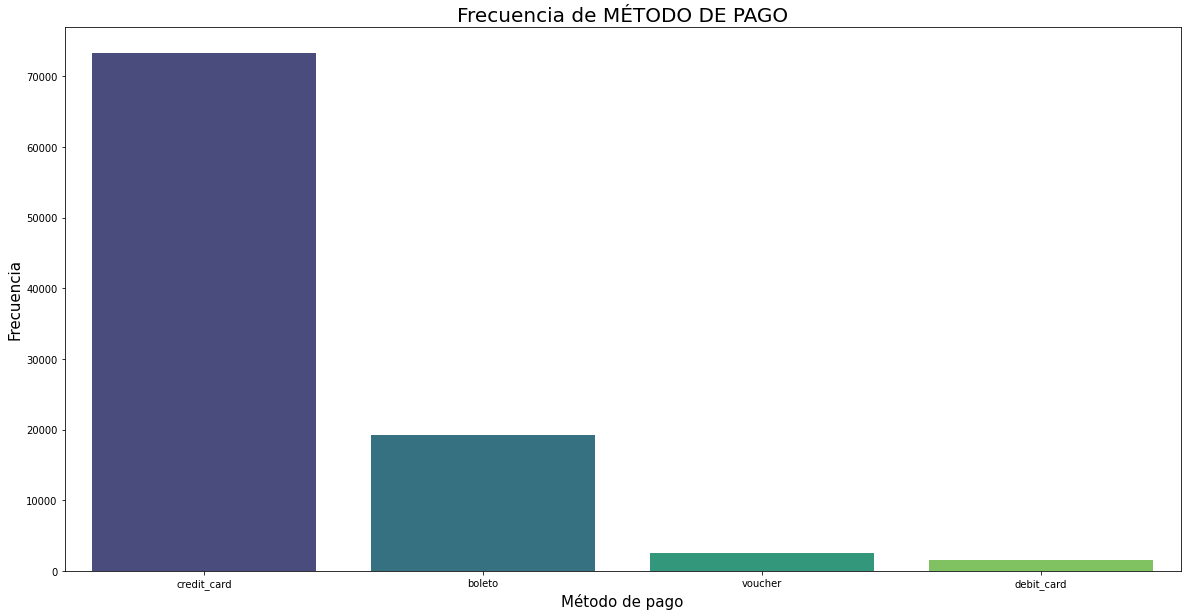

In [ ]:

#Vemos la cantidad de operaciones por  método de pago
fig = plt.figure(figsize=(20,10))
sns.countplot(x='payment_type', data=df, palette='viridis')
plt.ylabel('Frecuencia', fontsize=15)
plt.xlabel('Método de pago', fontsize=15)
plt.title('Frecuencia de MÉTODO DE PAGO', fontsize=20)

Según podemos observar en el gráfico. El método de pago más usado es el de tarjeta de crédito y el menor la tarjeta de debito.

In [ ]:
#TABLA DE FRECUENCIA de "Método de Pago"

#obtenemos los datos de "payment type" y los guardamos en una variable tipo serie
meto_pago= df["payment_type"].value_counts()

##Guardamos la información en un DF
meto_pago = pd.DataFrame(meto_pago)

#Asignamos el nombre F_absoluta a la columna
meto_pago.rename(columns={'payment_type':'F_absoluta'},inplace=True)

#Se usa un bucle 'for' para generar la tabla
F_absoluta_val = meto_pago["F_absoluta"].values
acumuladas = []
valor_acumulado = 0
for i in F_absoluta_val:
    valor_acumulado = valor_acumulado + i
    acumuladas.append(valor_acumulado)
    
meto_pago["F_abs_acumulada"] = acumuladas

#Frecuencia relativa porcentual
meto_pago["F_relativa_%"] = 100 * meto_pago["F_absoluta"]/len(df['payment_type'])

#Frecuencia relativa porcentual acumulada
F_relativa_val = meto_pago["F_relativa_%"].values
acumuladas = []
valor_acumulado = 0
for i in F_relativa_val:
    valor_acumulado = valor_acumulado + i
    acumuladas.append(valor_acumulado)
    
meto_pago["F_relativa_%_acumulada"] = acumuladas
meto_pago

,F_absoluta,F_abs_acumulada,F_relativa_%,F_relativa_%_acumulada
credit_card,73251,73251,75.895188,75.895188
boleto,19203,92454,19.896183,95.791371
voucher,2578,95032,2.671060,98.462431
debit_card,1484,96516,1.537569,100.000000


### 2) UNIVARIADO variable "reviews"/SCORE

Text(0.5, 1.0, 'Frecuencia de SCORE')

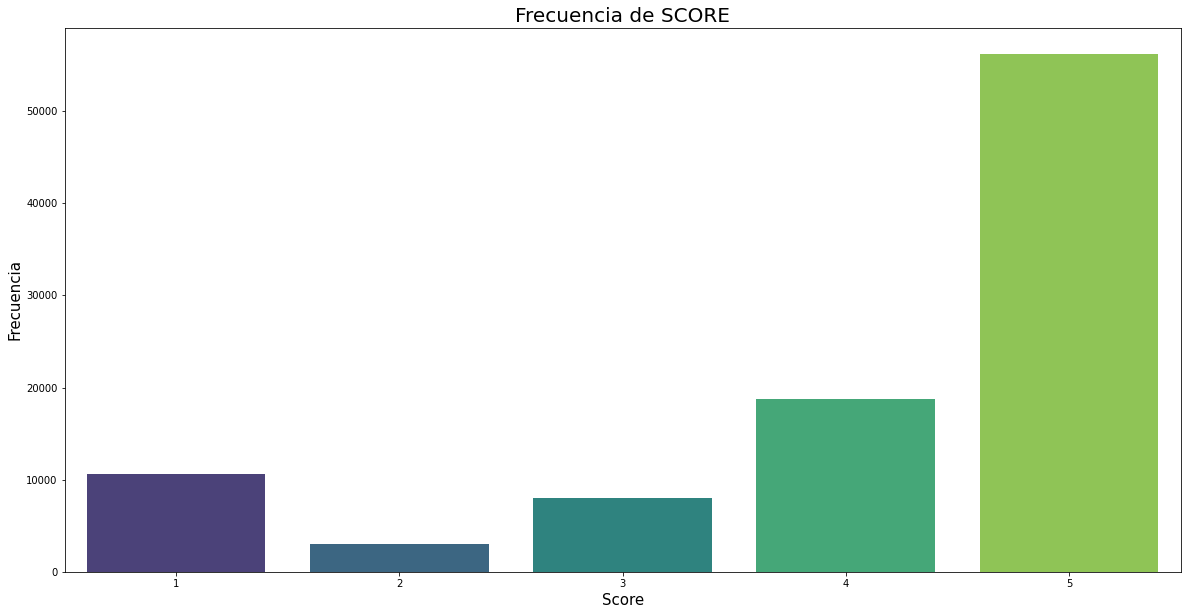

In [ ]:
#Vemos la cantidad de operaciones por calificaciones/SCORE
fig = plt.figure(figsize=(20,10))
sns.countplot(x='review_score', data=df, palette='viridis')
plt.ylabel('Frecuencia', fontsize=15)
plt.xlabel('Score', fontsize=15)
plt.title('Frecuencia de SCORE', fontsize=20)


Como se puede observar en el gráfico y la tabla de frecuencias a continuación, el 58% de las calificaciones está con una puntuación de 5.

In [ ]:
#TABLA DE FRECUENCIA de "reseñas"

#obtenemos los datos de "payment type" y los guardamos en una variable tipo serie
resenas= df["review_score"].value_counts()

##Guardamos la información en un DF
resenas = pd.DataFrame(resenas)

#Asignamos el nombre F_absoluta a la columna
resenas.rename(columns={'review_score':'F_absoluta'},inplace=True)

#Se usa un bucle 'for' para generar la tabla
F_absoluta_val1 = resenas["F_absoluta"].values
acumuladas1 = []
valor_acumulado1 = 0
for i in F_absoluta_val1:
    valor_acumulado1 = valor_acumulado1 + i
    acumuladas1.append(valor_acumulado1)
    
resenas["F_abs_acumulada"] = acumuladas1

#Frecuencia relativa porcentual
resenas["F_relativa_%"] = 100 * resenas["F_absoluta"]/len(df['review_score'])

#Frecuencia relativa porcentual acumulada
F_relativa_val1 = resenas["F_relativa_%"].values
acumuladas1 = []
valor_acumulado1 = 0
for i in F_relativa_val1:
    valor_acumulado1 = valor_acumulado1 + i
    acumuladas1.append(valor_acumulado1)
    
resenas["F_relativa_%_acumulada"] = acumuladas1
resenas

,F_absoluta,F_abs_acumulada,F_relativa_%,F_relativa_%_acumulada
5,56185,56185,58.213146,58.213146
4,18732,74917,19.408181,77.621327
1,10598,85515,10.980563,88.601890
3,7978,93493,8.265987,96.867877
2,3023,96516,3.132123,100.000000


###  3) UNIVARIADO variable "product_category_name"  top 10

Text(0.5, 1.0, 'Cantidad de items vendidos por categoría')

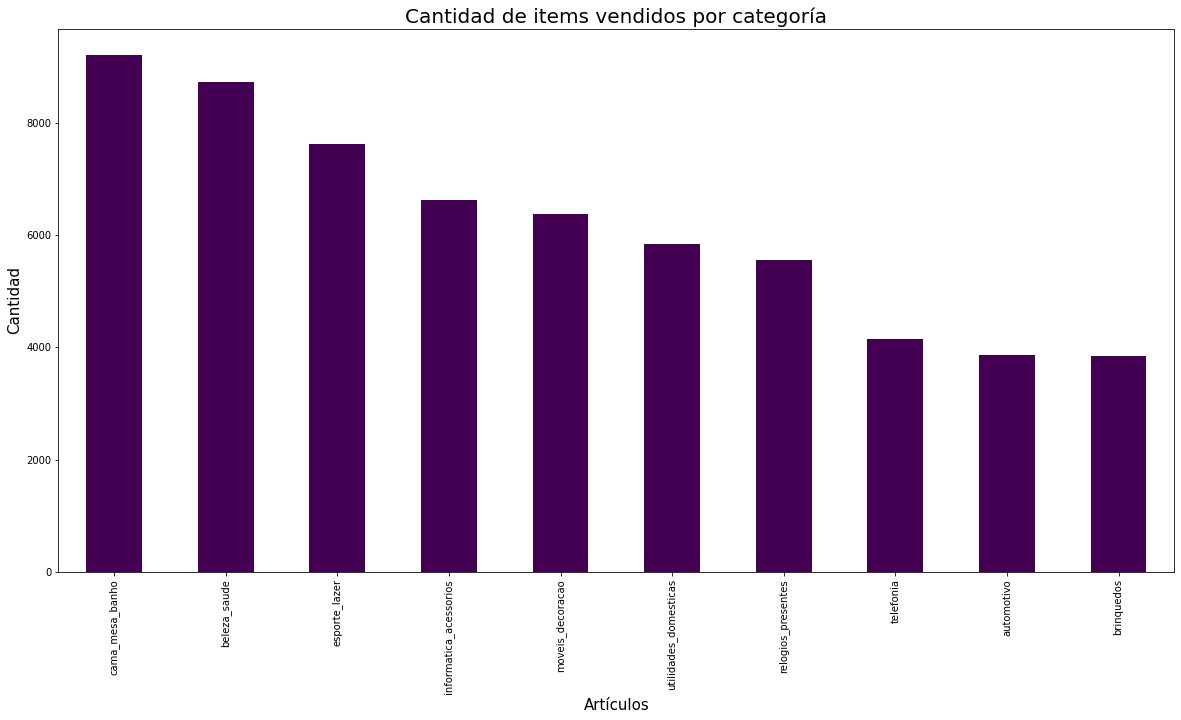

In [ ]:
#3) Graficamos un gráfico de barras con un top 10 de productos más vendidos
fig = plt.figure(figsize=(20,10))
categor = df['product_category_name'].value_counts().head(10)
categor.plot(kind="bar",cmap='viridis')
plt.ylabel('Cantidad', fontsize = 15)
plt.xlabel('Artículos', fontsize=15)
plt.title('Cantidad de items vendidos por categoría', fontsize = 20)

Según el gráfico anterior, vemos que la categoría con más artículos vendidos es la de "cama_mesa_banho";además, podemos observar que la cantidad de artículos vendidos no cambian drásticamente entre una categoría y otra, pero marcando una disminución un poco significativa a partir de la octava categoría.

### 4) UNIVARIADO de price

Text(0.5, 0, 'Precio')

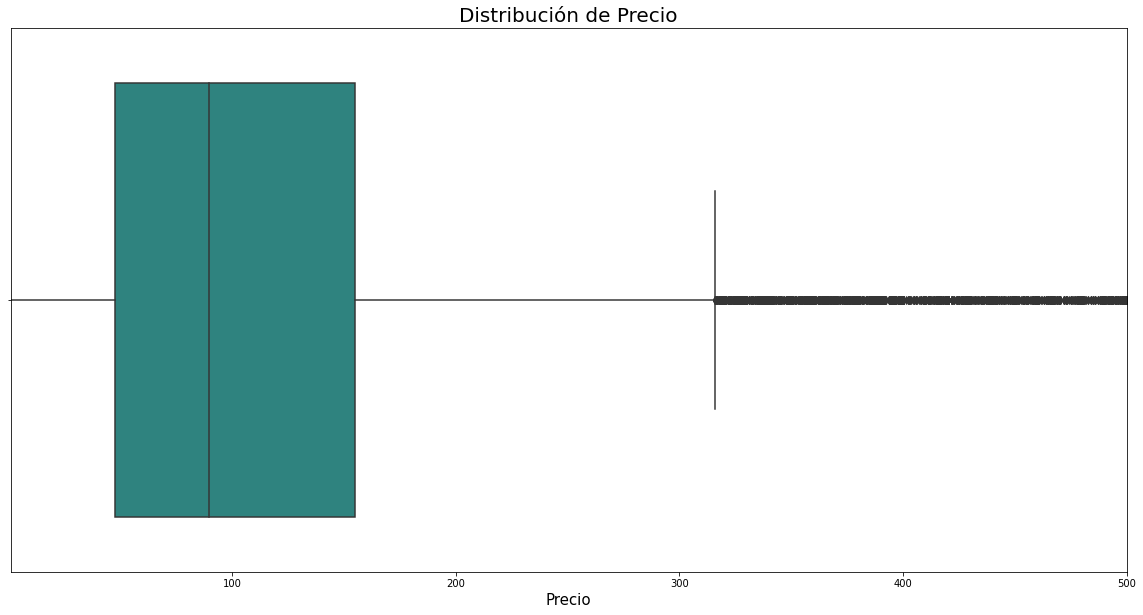

In [ ]:
#Graficamos un boxplot para ver la distribución del precio y establecimos un límite de 500 porque hay unos outliers que
# afectan la visualización del gráfico
fig = plt.figure(figsize=(20,10))
sns.boxplot(x='precio', data =df, palette='viridis')
plt.xlim(1,500)
plt.title('Distribución de Precio',fontsize =20 )
plt.xlabel('Precio', fontsize=15)

Como se puede observar en el boxplot graficado, la distribución de precios de 

*   Elemento de la lista
*   Elemento de la lista

todos los articulos se encuentra principalmente en los rangos de 47.7 y 155 reales, siendo estos el segundo y tercer cuantil respectivamente. 

###  5) UNIVARIADO de la variable "freight"

Text(0.5, 0, 'Precio del flete')

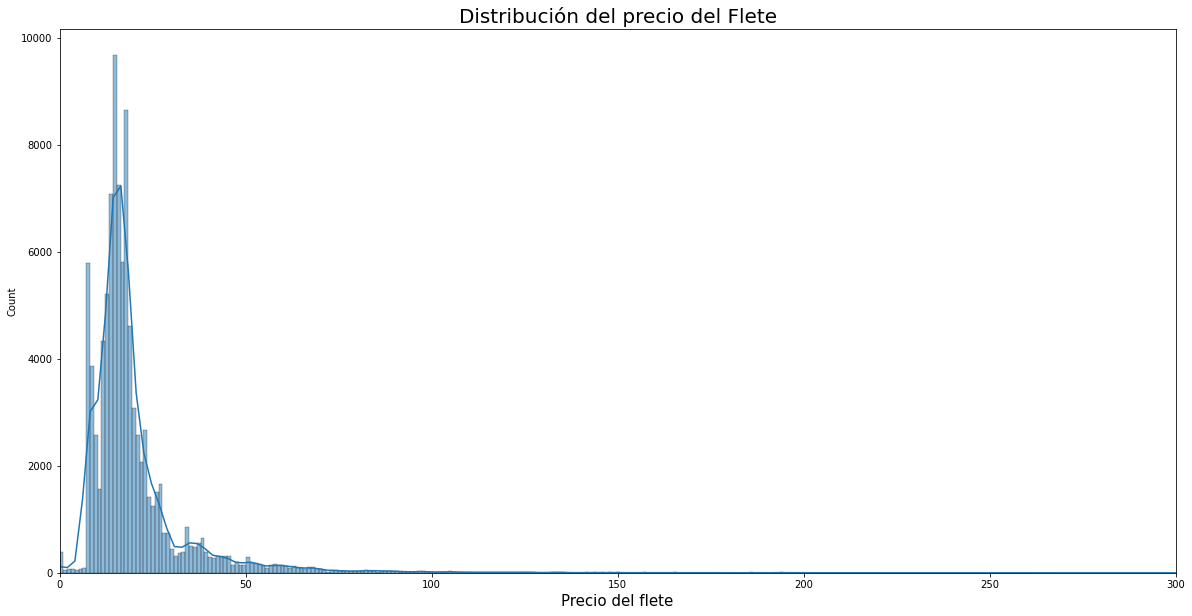

In [ ]:
#Graficamos la distribución del precio del flete
fig = plt.figure(figsize=(20,10))
sns.histplot(x='freight_value',bins=400, kde=True, data=df, palette='BuGn')
plt.xlim(0,300)
plt.title('Distribución del precio del Flete', fontsize=20)
plt.xlabel('Precio del flete',fontsize=15)

Según el histograma de la variable "freight_value" , la distribución del valor del flete de todos los articulos se encuentra principalmente en los rangos de 13.3 y 21.26 reales, siendo estos el segundo y tercer cuantil respectivamente. Además, se puede observar que hay órdenes que tiene un flete sin valor (0.0), lo cual nos da a entender que hay órdenes con envío gratis.

### 6) UNIVARIADO de las variables de ciudades y estados

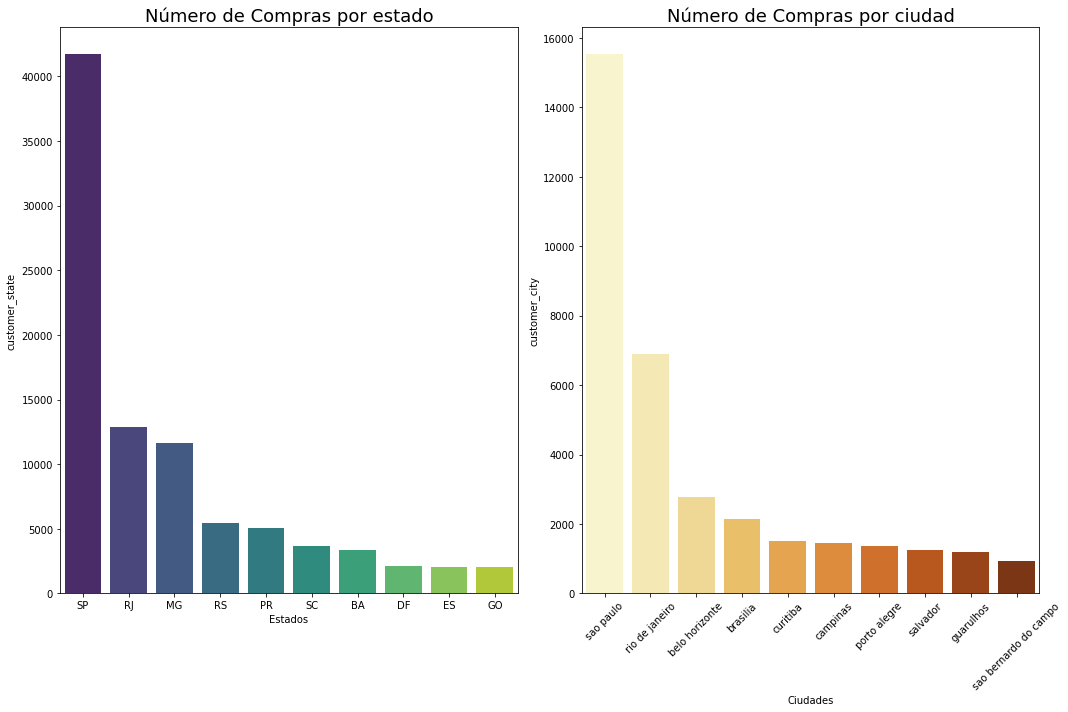

In [ ]:
# Estados y Ciudades que más compraron
#Creamos los dataframes con el iloc para que solo nos de las 10 primeras de cada una.
estados = pd.DataFrame(customers["customer_state"].value_counts().iloc[:10])
ciudades = pd.DataFrame(customers["customer_city"].value_counts().iloc[:10])

# Se plotean
fig, ax= plt.subplots(ncols=2, figsize=(15,10))

sns.barplot(x=estados.index, y='customer_state', palette ="viridis", data=estados, ax=ax[0])

sns.barplot(x= ciudades.index,y='customer_city',palette="YlOrBr",data=ciudades, ax=ax[1])

ax[0].set_title('Número de Compras por estado', fontsize=18)
ax[1].set_title('Número de Compras por ciudad', fontsize=18)
ax[0].tick_params(axis='x')
ax[1].tick_params(axis='x', labelrotation=45)
ax[0].set_xlabel("Estados")
ax[1].set_xlabel("Ciudades")
fig.tight_layout()

Decidimos graficar los estados en un mismo canva pero en diferentes gráficos ya que es información relacionada. A simple vista podemos observa que el estado de SP (São Paulo) y su respectiva capital concentran la mayor cantidad de compras, siendo la diferencia muy significativa en comparación a las demás.

# ANALISIS BIVARIADO

### Mapa de Calor - correlaciones 

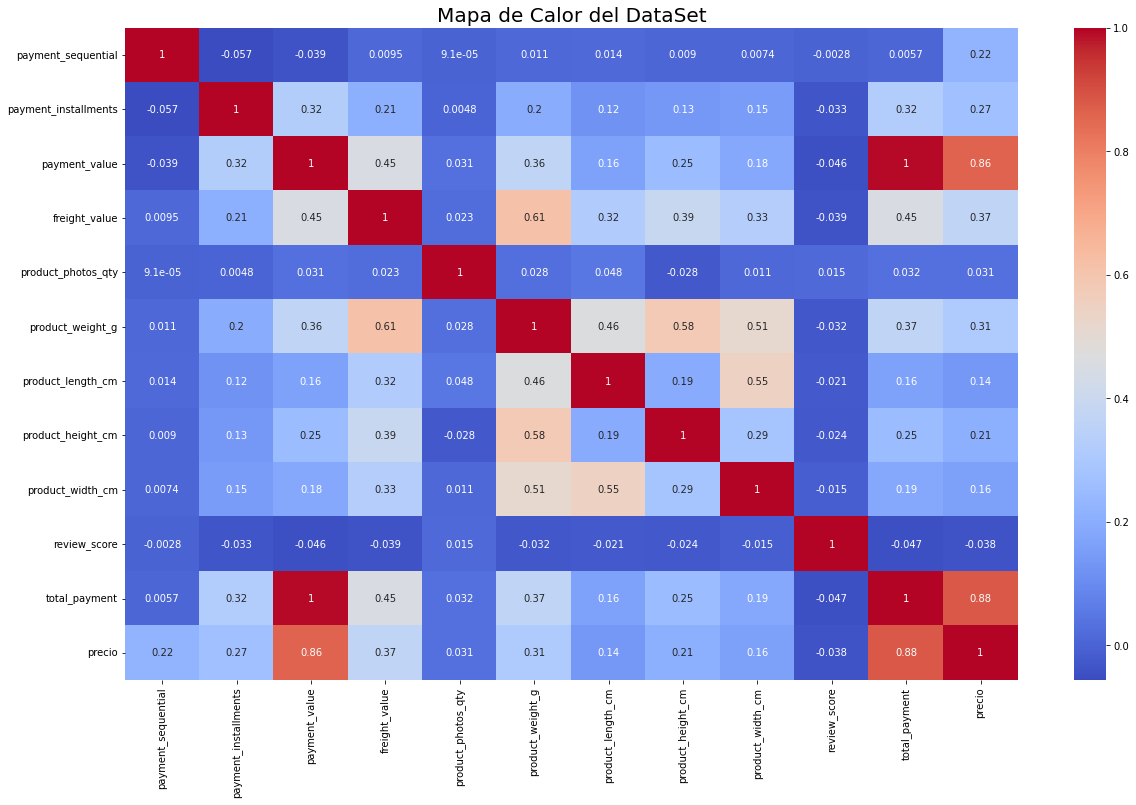

In [ ]:

plt.figure(figsize=(20, 12)) 
sns.reset_orig()
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')
plt.title('Mapa de Calor del DataSet', fontsize = 20)
plt.show()

Analizando la información presentada, las variables no presentan una correlación significativa entre ellas. Siendo la excepción la correlación media (55%-61%) entre las variables de medidas y peso ("product_weight_gm", product_height_cm" y "product_width_cm) y "freight_value", lo cual es de esperarse ya que entre más pese y mida un producto, se espera que su valor de flete sea mayor.

### Data Profiling

De manera introductoria, usamos la libreria "Profiling" para identificar de una manera más clara la correlaciones más directas entre las variables.

In [ ]:
#!pip install --upgrade pandas_profiling --user #instalamos paquete
#profile = pandas_profiling.ProfileReport(df) # guardamos el resultado en una variable
#profile #corremos 

### Categorías con Mayor número de reviews VS. Categorías con Mejores reviews 

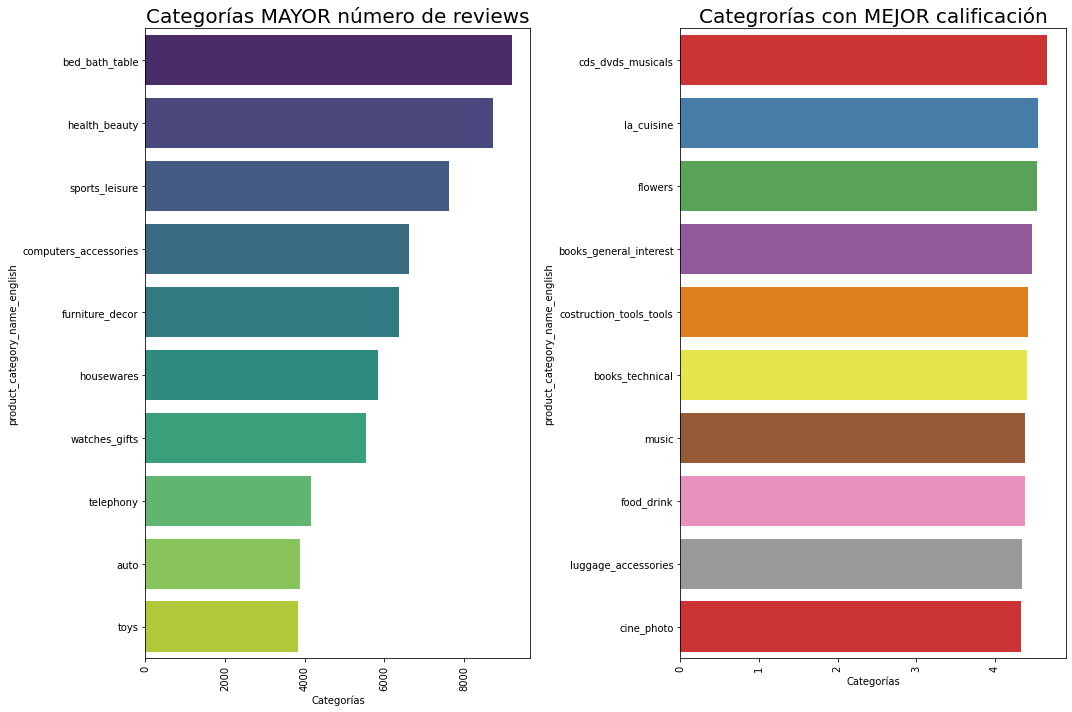

In [ ]:
#categorias con MAYOR numero de reviewsy usamos el .iloc para que solo nos de´el top 10
Cat_rev = pd.DataFrame(df.groupby("product_category_name_english")["review_score"].count().sort_values(ascending= False).iloc[:10])
#categorias con MEJORES promedios de review y se usa nuevamente el .iloc para el top 10
Cat_rev_prom_top = pd.DataFrame(df.groupby("product_category_name_english")["review_score"].mean().sort_values(ascending= False).iloc[:10])
Cat_rev_prom_top = Cat_rev_prom_top.rename(columns = {'review_score':'prom_rev'})

# # Se plotean
fig, ax= plt.subplots(ncols=2, figsize=(15,10))
sns.barplot(x="review_score", y=Cat_rev.index ,palette="viridis", data=Cat_rev, ax=ax[0])
sns.barplot(x= "prom_rev",y=Cat_rev_prom_top.index ,palette="Set1",data=Cat_rev_prom_top, ax=ax[1])

ax[0].set_title('Categorías MAYOR número de reviews', fontsize=20)
ax[1].set_title('Categrorías con MEJOR calificación', fontsize=20)
ax[0].tick_params(axis='x',labelrotation=90)
ax[1].tick_params(axis='x', labelrotation=90)
ax[0].set_xlabel("Categorías")
ax[1].set_xlabel("Categorías")
fig.tight_layout()

Se realizó la comparación anterior con el fin de visualizar si las categorías con mayor reviews eran las mismas que tenían las mejores calificaciones. Como se puede observar, ninguna de las categorías que tienen mayor número de reviews están dentro de las mejores calificadas.

### Categorías con más ventas vs. Categorias con más articulos vendidos

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


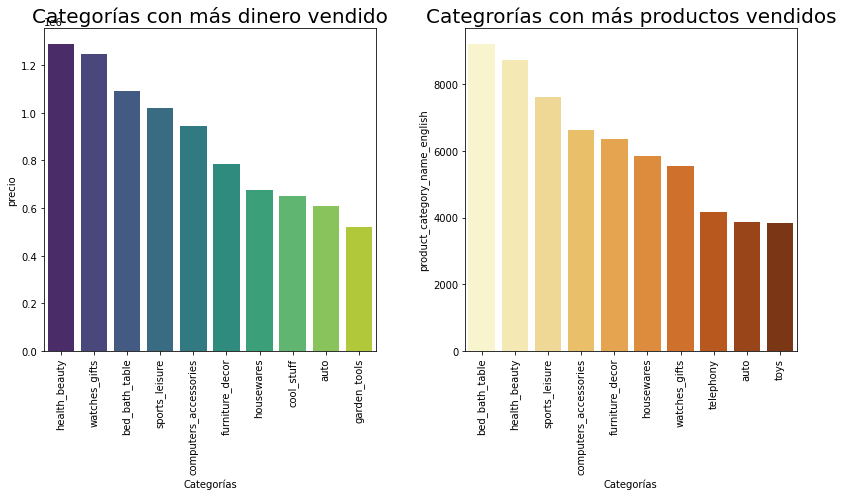

In [ ]:

#Creamos los dataframes con el iloc para que solo nos de las 10 primeras de cada una.
cate_ventas = pd.DataFrame(df.groupby('product_category_name_english')["product_category_name_english",'precio'].sum().sort_values("precio",ascending= False).iloc[:10])
cate_artic = pd.DataFrame(df["product_category_name_english"].value_counts().iloc[:10])

# # Se plotean
fig, ax= plt.subplots(ncols=2, figsize=(12,7))

sns.barplot(x=cate_ventas.index, y='precio',palette="viridis", data=cate_ventas, ax=ax[0])
sns.barplot(x= cate_artic.index,y='product_category_name_english',palette="YlOrBr",data=cate_artic, ax=ax[1])

ax[0].set_title('Categorías con más dinero vendido', fontsize=20)
ax[1].set_title('Categrorías con más productos vendidos', fontsize=20)
ax[0].tick_params(axis='x',labelrotation=90)
ax[1].tick_params(axis='x', labelrotation=90)
ax[0].set_xlabel("Categorías")
ax[1].set_xlabel("Categorías")
fig.tight_layout()

Según la comparación realizada en los gráficos anteriores, se puede observar las categorías no varían mucho en su orden cuando se compara la cantida de dinero producido al volumen de ventas. Sin embargo, hay unas categorías que no siguen este patrón; por ejemplo, la categoría de "watches_gifts" resalta entre las que más vende, pero para nuestra sorpresa, no está entre las que más unidades vende.   

# MULTIVARIADO

### 1) Scatterplot entre las variables de "payment_value" vs "precio" y "payment_type" 

Text(0.5, 1.0, 'Valor pagado vs Precio')

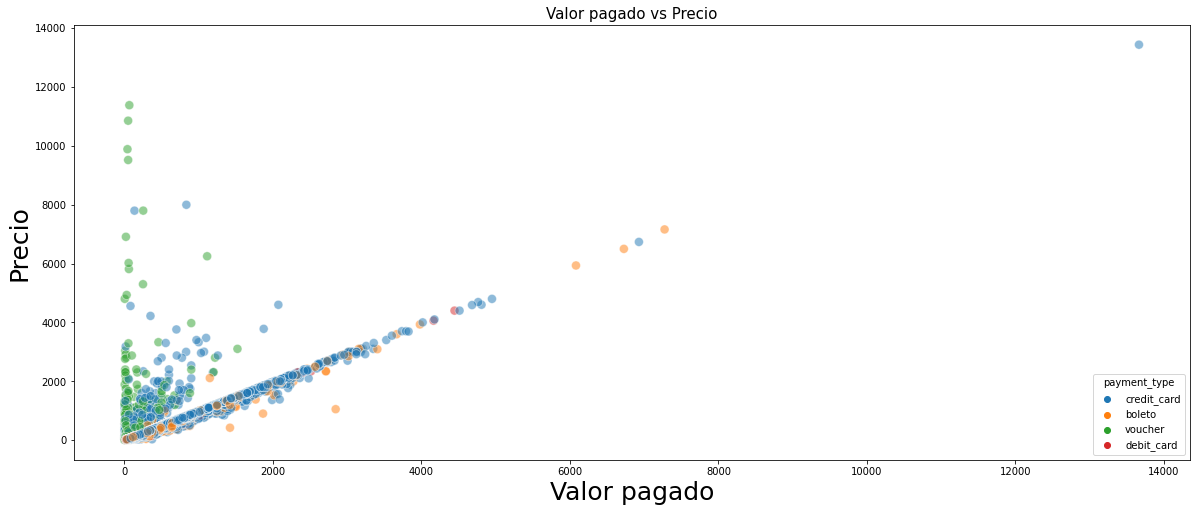

In [ ]:
plt.figure(figsize=(20,8))
sns.scatterplot(x='payment_value',y='precio',data=df,hue='payment_type',s=80,alpha=0.5,color= 'blue')
plt.xlabel('Valor pagado', size= 25)
plt.ylabel('Precio', size= 25)
plt.title('Valor pagado vs Precio',fontsize=15)

Podemos observar que, la mayoría personas aplica sus vouchers para pagos menores a R1000 (quizás por disposición de la empresa solo se pueden aplicar vouches con un tope de pago máximo)

### Analizamos las fechas de Entregas

In [ ]:
## Vamos a analizar las entregas, primero pasando a serie de tiempo las variables... 
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date']= pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date']= pd.to_datetime(df['order_estimated_delivery_date'])

#Agregando columnas "dias reales" y "dias estimados"
df['dias_reales']= (df['order_delivered_customer_date']-df['order_purchase_timestamp']).dt.days
df['dias_estimados']= (df['order_estimated_delivery_date']-df['order_purchase_timestamp']).dt.days

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


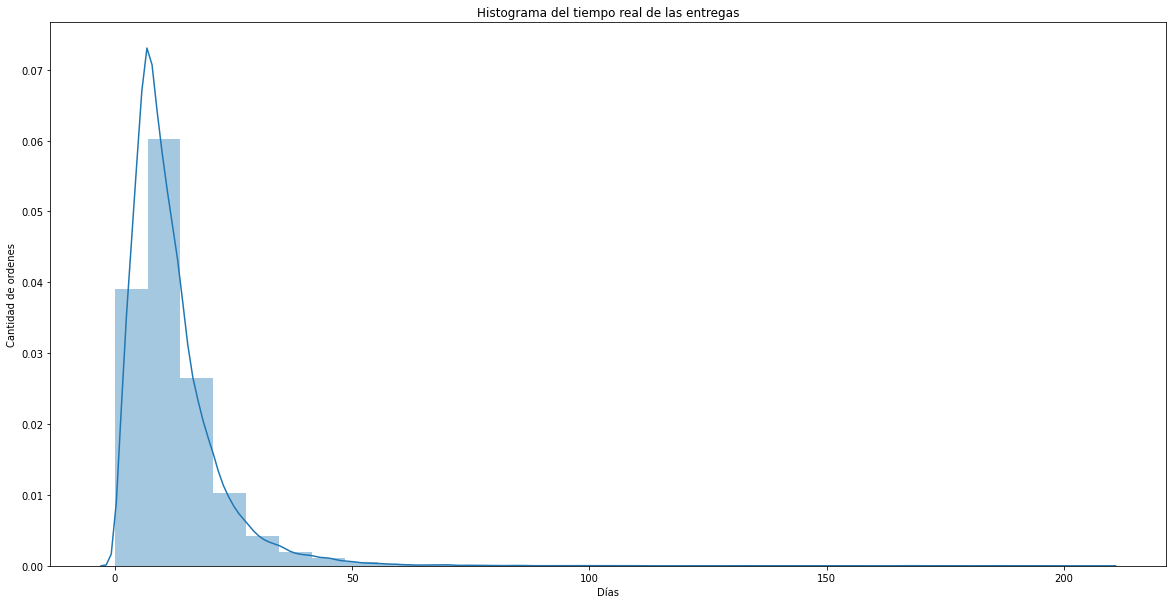

In [ ]:
##Histograma del tiempo real de las entregas
plt.figure(figsize=(20,10))
sns.distplot(df['dias_reales'], kde=True, hist=True, bins=30)
plt.xlabel('Días')
plt.ylabel('Cantidad de ordenes')
plt.title('Histograma del tiempo real de las entregas')

plt.show()

Como se puede observar en el gráfico anterior, podemos observar que el promedio de entrega se encuentra en los 12 días.

### Comparación de Días reales de entrega Vs Días de entrega estimados

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


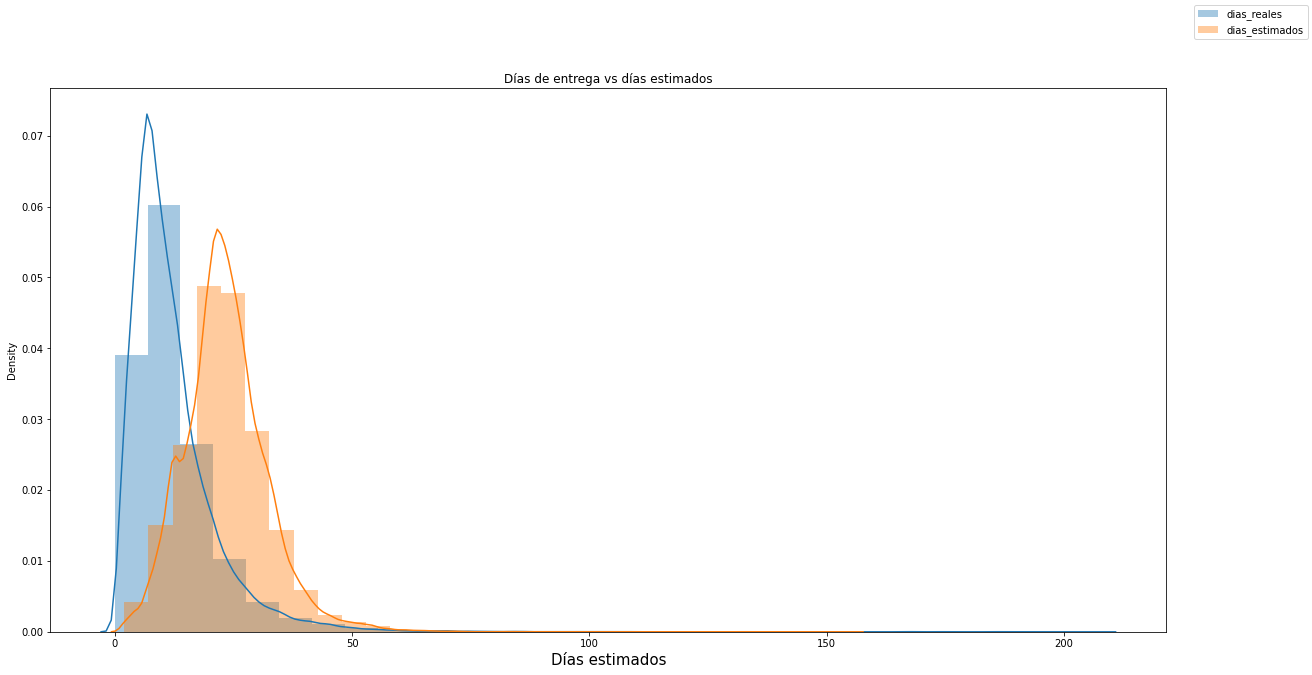

In [ ]:
fig = plt.figure(figsize=(20,10))

sns.distplot(df['dias_reales'], kde=True, hist=True, bins=30, label='dias_reales')
sns.distplot(df['dias_estimados'], kde=True, hist=True, bins=30, label='dias_estimados')
fig.legend()
plt.xlabel('Días estimados', fontsize = 15)
plt.title('Días de entrega vs días estimados')

plt.show()

Pudimos notar que los días de entregas reales son en promedio 11 días menos a días de entrega estimados por el sistema de entrega.

### Graficamos la diferencia entre los días reales y lo estipulado...

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


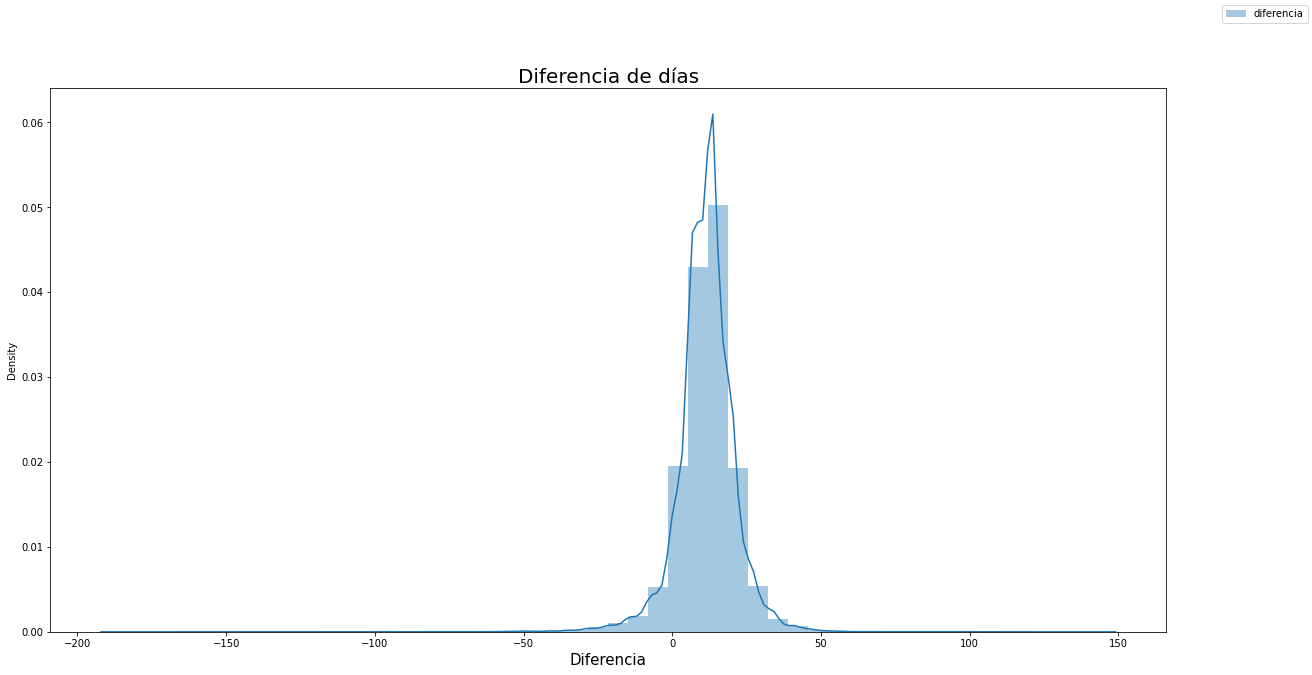

In [ ]:
##Graficamos la diferencia entre los días reales y lo estipulado...
fig = plt.figure(figsize=(20,10))
sns.distplot(df['dias_estimados']-df['dias_reales'], kde=True, hist=True, bins=50, label='diferencia')
fig.legend()
plt.xlabel('Diferencia', fontsize = 15)
plt.title('Diferencia de días', fontsize= 20)

plt.show()

### Analizamos las entregas mes a mes

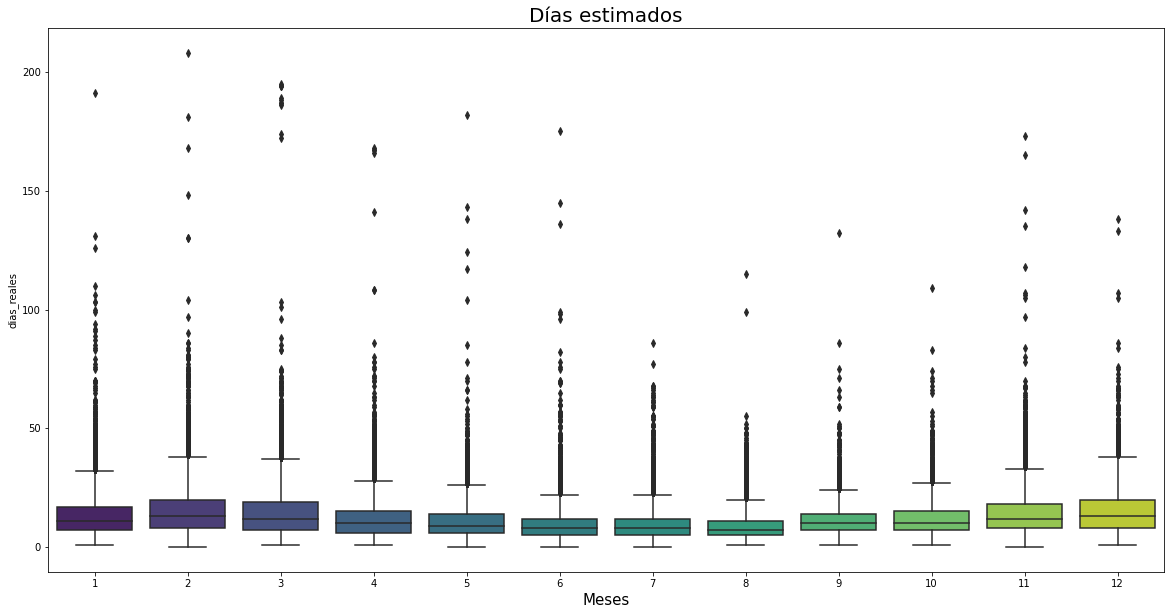

In [ ]:
##Analizamos las entregas mes a mes
plt.figure(figsize=(20,10))
sns.boxplot(x=df['order_purchase_timestamp'].dt.month, y=df['dias_reales'],data=df,palette='viridis', orient='v')
plt.xlabel('Meses', fontsize = 15)
plt.title('Días estimados', fontsize = 20)
plt.show()

En esta gráfica notamos que el tiempo promedio de días reales de entrega es 

1.   Elemento de la lista

1.   Elemento de la lista
2.   Elemento de la lista


2.   Elemento de la lista

menor a mitad de año julio/agosto

### Analizamos las entregas de las entregas en los 3 años de registros

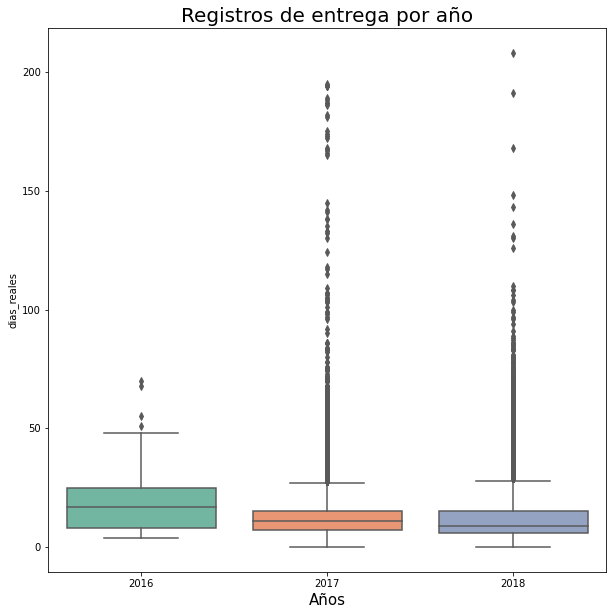

In [ ]:

plt.figure(figsize=(10,10))
sns.boxplot(x=df['order_purchase_timestamp'].dt.year, y=df['dias_reales'],data=df,palette='Set2', orient='v')
plt.xlabel('Años', fontsize = 15)
plt.title('Registros de entrega por año', fontsize = 20)
plt.show()

Aquí podemos notar que el promedio más bajo de días lo tiene el año 2018, seguido por el 2017 y finalmente el 2016(en este último también hay que tener en cuenta que son muchísimas menos ordenes que en los demás años)

###  Analisis sobre los productos

In [ ]:
#Aislamos los productos, los agrupamos por categoría y luego realizamos el conteo para finalmente nombrar la variable "total"
productos = df.groupby(['product_category_name_english'], as_index=False)
productos = productos['order_id'].count().rename( columns = {'order_id':'total'})


#Agregamos frecuencia relativa
productos['%'] = round((productos['total'] / productos['total'].sum()) * 100, 2)
productos

,product_category_name_english,total,%
0,agro_industry_and_commerce,182,0.19
1,air_conditioning,248,0.26
2,art,194,0.20
3,arts_and_craftmanship,21,0.02
4,audio,341,0.35
...,...,...,...
66,stationery,2291,2.37
67,tablets_printing_image,74,0.08
68,telephony,4157,4.31
69,toys,3843,3.98


### Graficamos los 20 productos y su representación porcentual en la cantidad de órdenes

Text(0, 0.5, 'Categoría')

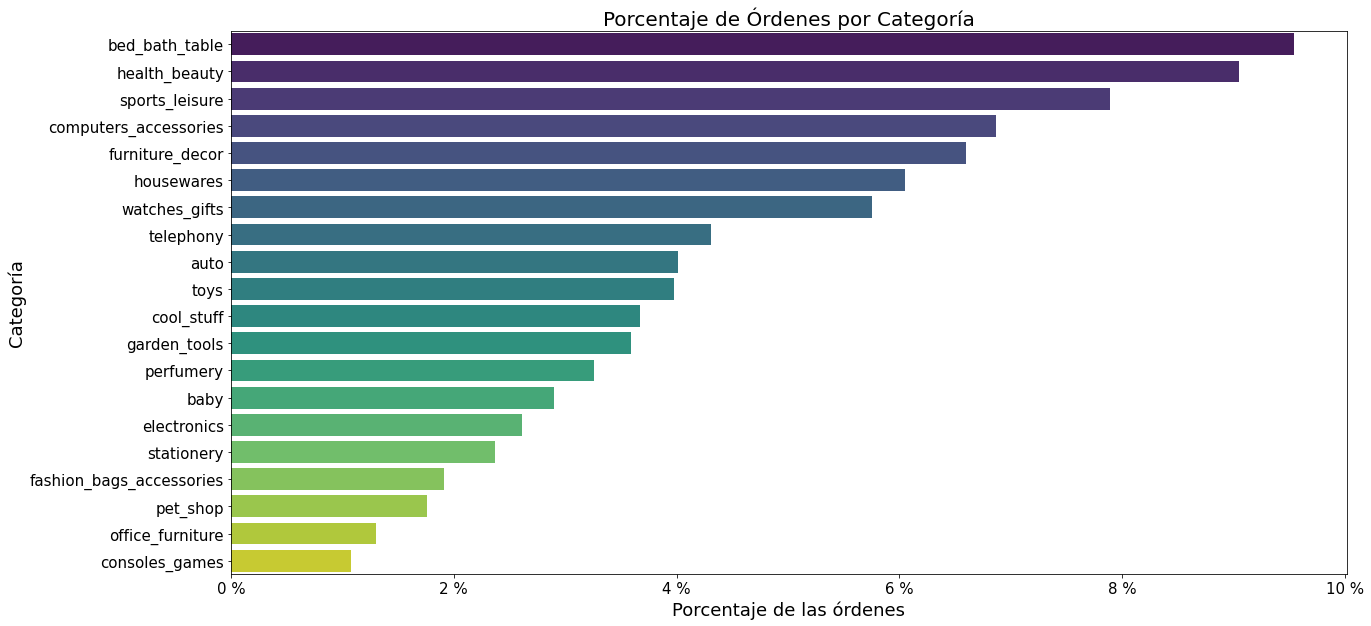

In [ ]:
plt.figure(figsize=(20,10))

sns.barplot(y='product_category_name_english', x='%', palette='viridis', data=productos.nlargest(20, '%'))
plt.yticks(fontsize=15)
plt.xticks([0,2,4,6,8,10],['0 %', '2 %', '4 %', '6 %', '8 %', '10 %'], fontsize=15)
plt.xlabel("Porcentaje de las órdenes", fontsize=18)
plt.title('Porcentaje de Órdenes por Categoría', size=20)
plt.ylabel("Categoría", fontsize=18)

Este gráfico nos sirvió para identificar la incidencia de la cantidad de ordenes (representadas en porcentajes) en cada categoría. Los articulos de baño y cama son los más demandados.

## PCA

In [ ]:
#Seleccionamos las columnas que nos interesan para el modelo
df_modelo = df[['order_status','customer_id', 
           'freight_value', 'precio', 'payment_type','review_score','dias_estimados', 
           'order_purchase_timestamp']]

In [ ]:
#Vamos a dividir la fecha de compra en AÑO, MES, DÍA y HORA... y agregarlas como columnas
df_modelo['año_de_compra'] = pd.to_datetime(df_modelo['order_purchase_timestamp']).dt.year
df_modelo['mes_de_compra'] = pd.to_datetime(df_modelo['order_purchase_timestamp']).dt.month
df_modelo['dia_de_compra'] = pd.to_datetime(df_modelo['order_purchase_timestamp']).dt.day
df_modelo['hora_de_compra'] = pd.to_datetime(df_modelo['order_purchase_timestamp']).dt.hour

# Se elimina la columna de fecha de compra ya que se hizo la diviión de año-mes-día
df_modelo = df_modelo.drop(columns=['order_purchase_timestamp'])

#Extraemos la data numérica del data set
df_modelo_numeric = df_modelo._get_numeric_data()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
#Importamos librería para estandarizar los valores

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [ ]:
# Hacemos la estandarización
scaler.fit(df_modelo_numeric)

# Transformación con el método de promedio
scaler.transform(df_modelo_numeric).mean(axis=0)

# Asignamos la objeto a una variable
datos_standard = scaler.transform(df_modelo_numeric)

In [ ]:
## Importamos librería y Calculamos componentes principales
from sklearn.decomposition import PCA
pca = PCA()

# ajustamos los datos estandarizados
pca.fit(datos_standard)

# Transformamos los datos a PCA
pca.transform(datos_standard)

## Variabilidad explicada por cada componente
pca_analisis = pca.explained_variance_ratio_

# Nosotros prefirimos pasarlo a un DF para mejor visualización
pca_analisis = pd.DataFrame(pca_analisis).T

## Variabilidad acumulada
pca.explained_variance_ratio_.cumsum()

array([0.19438813, 0.38360495, 0.51027753, 0.6360143 , 0.75949468,
       0.87776828, 0.95337033, 1.        ])

Notamos que no hay una variabilidad interesante en los PCA obtenidos del df seleccionado para el modelo, creemos que necesitamos encarar este análisis desde otra mirada... probablemente partiendo desde una tabla de reciencia, frecuencia y valor monetario de los consumidores para posteriormente instanciar un Clustering

# II. SEGUNDA ENTREGA Y MEJORA DE MODELOS

### 2. Regresiones lineares, logistica y múltiple

Para fines prácticos Fecha de compra (X) y Fecha límite de envío (Y) se dividieron en día, mes y año por separado. En consecuencia se puede desarrollar la regresión lineal para cada una de estas 3 variables. En este caso nos enfocamos en los meses.


### 2.1 Regresion Linear Simple

In [ ]:
#Order purchase timestamp por separado (x)

#Año
df['año (X)'] = pd.DatetimeIndex(df['order_purchase_timestamp']).year
#Mes 
df['mes (X)'] = pd.DatetimeIndex(df['order_purchase_timestamp']).month
#Dia 
df['día (X)'] = pd.DatetimeIndex(df['order_purchase_timestamp']).day

#Shipping_limit_date por separado (variable target y)

#Año
df['año (Y)'] = pd.DatetimeIndex(df['shipping_limit_date']).year
#Mes 
df['mes (Y)'] = pd.DatetimeIndex(df['shipping_limit_date']).month
#Dia 
df['día (Y)'] = pd.DatetimeIndex(df['shipping_limit_date']).day


In [ ]:
#Ubicar los meses para Fecha de compra y Fecha límite de envío 
Ubicar = df[['mes (X)', 'mes (Y)']]
Ubicar

,mes (X),mes (Y)
0,10,10
3,8,8
4,8,8
5,10,10
6,11,11
...,...,...
115603,4,4
115604,8,8
115605,7,7
115607,1,1


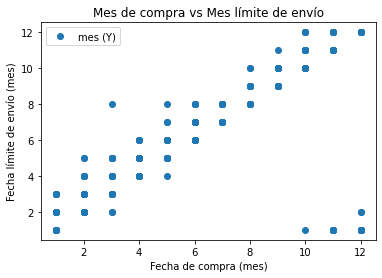

In [ ]:
#Graficamos los meses 
Ubicar.plot(x='mes (X)', y='mes (Y)', style="o")
plt.title('Mes de compra vs Mes límite de envío')
plt.xlabel('Fecha de compra (mes)')
plt.ylabel('Fecha límite de envío (mes)')
plt.show()

In [ ]:
#Preparacion de datos
X = Ubicar.iloc[:, :-1].values
y = Ubicar.iloc[:, 1].values

In [ ]:
#Empezamos a crear nuestro modelo
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
X_test
X_test.shape

(19304, 1)

In [ ]:
#Entrenando el modelo
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [ ]:
#Recuperamos la intersección (b)
print(regressor.intercept_)

0.50621285526947


In [ ]:
#La pendiente (coeficiente m)
print(regressor.coef_)

[0.93025535]


In [ ]:
#Hacemos nuestras predicciones
y_pred = regressor.predict(X_test)
y_pred

array([ 5.1574896 ,  7.94825564,  1.4364682 , ...,  7.94825564,
       10.73902169,  8.87851099])

In [ ]:
#Revisamos el accuracy del modelo
print('Accuracy de la Regresión Lineal en training set: {:.4f}'
     .format(regressor.score(X_train, y_train)))
print('Accuracy de Regresión Lineal en test set: {:.4f}'
     .format(regressor.score(X_test, y_test)))

Accuracy de la Regresión Lineal en training set: 0.8728
Accuracy de Regresión Lineal en test set: 0.8705


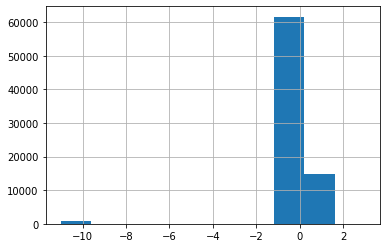

In [ ]:
#Convertimos en df la salida
test_vs_pred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
test_vs_pred
y_train.reshape(1,-1)[0]
X_train.reshape(1,-1)[0]
train = pd.DataFrame({'Fecha de compra (mes)':X_train.reshape(1,-1)[0],'Fecha límite de envío (mes)':y_train.reshape(1,-1)[0]})
train["Diferencia de meses"] = train["Fecha límite de envío (mes)"] - train["Fecha de compra (mes)"] 
train["Diferencia de meses"].hist()

Podemos ver que en la mayoría de los envios, las órdenes se entreguen dentro del mes siguiente a la fecha de compra. Y como se especificó anteriormente, esta regresión puede aplicarse en días, meses y años.

### 2.2 Regresión Logística


En un ejercicio, hay que predecir cuál es la probabilidad para pedidos aleatorios su estatus de orden en función de su logística tiempo.

Vale mencionar que para x (estatus de orden) el valor es como sigue: 1 = entregado (delivered), 2 = enviado (shipped), 3 = facturado (invoiced) e y la logística tiempo en días

Al ser un evento aleatorio la ejecución del código arrojaría nuevos pedidos cada vez, por lo que los 15 pedidos aleatorios la primera vez fueron: 106236, 42304, 15846, 91523, 40848, 221

In [ ]:
#paso 1
X = np.array([1, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1]).reshape(-1,1)  #Predomina el estatus delivered para Considerar_vars
y = np.array([8, 6, 6, 5, 8, 4, 9, 6, 9, 28, 6, 9, 4, 7, 8])

##Logística_tiempo-----------días para llegar (diferencia entre la fecha límite de envío y la fecha de compra)
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])
df['Logistica_tiempo'] = df['shipping_limit_date']-df['order_purchase_timestamp'] 
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,precio,dias_reales,dias_estimados,año (X),mes (X),día (X),año (Y),mes (Y),día (Y),Logistica_tiempo
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,credit_card,...,89.97,8.0,15,2017,10,2,2017,10,6,4 days 00:10:42
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1,credit_card,...,29.99,2.0,12,2017,8,15,2017,8,21,6 days 01:35:45
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1,credit_card,...,29.99,5.0,12,2017,8,2,2017,8,8,6 days 00:12:44
5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13,1,boleto,...,29.99,14.0,20,2017,10,23,2017,10,31,7 days 02:47:25
6,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21,1,credit_card,...,339.00,33.0,26,2017,11,24,2017,11,30,5 days 02:53:21


In [ ]:
# Preparación de datos
equis = df.sample(n=15)
Sample_equis = pd.DataFrame(equis)
Sample_equis[['order_status','Logistica_tiempo']]

,order_status,Logistica_tiempo
79687,delivered,6 days 23:56:24
102817,delivered,4 days 00:15:22
85514,delivered,4 days 00:13:36
97074,delivered,6 days 00:25:49
11393,delivered,3 days 00:23:44
70960,delivered,8 days 00:49:11
64477,delivered,6 days 05:49:40
44870,delivered,5 days 18:48:35
92996,delivered,4 days 00:18:39
85247,delivered,16 days 00:11:39


In [ ]:
#Entrenamos un modelo de regresión logística

# Paso 2: Creamos una instancia de la Regresión Logística
regresion_logistica = LogisticRegression()

# Paso 3: Entrenamos la regresión logística con los datos de entrenamiento
regresion_logistica.fit(X,y)

#Hacemos la predicción para nuevos estatus de orden : 4 (cancelado), 5 (procesando) , 6 (no disponible) y 
#7 (aprobado) --Considerar_vars['order_status'].value_counts()--
X_nuevo = np.array([4, 5, 6, 7]).reshape(-1,1)

# Paso 4: Usa el modelo entrenado para obtener las predicciones con datos nuevos
prediccion = regresion_logistica.predict(X_nuevo)
print(prediccion)


[28 28 28 28]


 Como podemos observar los nuevos estatus de orden (cancelado, procesando, no disponible y aprobado) nos arrojarían 28 días en su logística tiempo.


In [ ]:
# Paso 6: Opcionalmente, obtenemos las probabilidades de la predicción
probabilidades_prediccion = regresion_logistica.predict_proba(X_nuevo)
print(probabilidades_prediccion)

[[3.30511167e-02 2.25578859e-02 1.88216705e-01 2.25578859e-02
  3.87515253e-02 3.87515253e-02 6.56113356e-01]
 [1.05409586e-02 8.02201586e-03 8.69157851e-02 8.02201586e-03
  1.13448197e-02 1.13448197e-02 8.63809585e-01]
 [2.81771704e-03 2.39106806e-03 3.36405005e-02 2.39106806e-03
  2.78374658e-03 2.78374658e-03 9.53192153e-01]
 [7.04993878e-04 6.67069456e-04 1.21870035e-02 6.67069456e-04
  6.39340905e-04 6.39340905e-04 9.84495182e-01]]


In [ ]:
# Observamos las siguientes probabilidades para el estatus de orden 4,5,6 y 7 
print(probabilidades_prediccion[:,1])

[0.02255789 0.00802202 0.00239107 0.00066707]


### 2.3 Regresión Multiple

Para fines prácticos Fecha de compra (X) y Fecha límite de envío (Y) se dividieron en día, mes y año por separado. En consecuencia la regresión múltiple comprende estas 3 variables.

In [ ]:
#Preparación de datos

X = df[['año (X)', 'mes (X)', 'día (X)']] # fecha de compra completa
y = df[['año (Y)', 'mes (Y)', 'día (Y)']] # fecha límite de envío completa

#Separacion en train y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Entrenamiento del modelo
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

Como se dijo anteriormente, en caso de regresión lineal multivariable, el modelo de regresión tiene que encontrar los coeficientes más óptimos para todos los atributos.

In [ ]:
#Las pendientes (coeficientes m)
print(regressor.coef_)

[[ 0.99923602  0.00549754  0.00142556]
 [-0.03223155  0.92761857  0.01304338]
 [ 0.01710515  0.08007199  0.08106987]]


In [ ]:
X.columns
coeff_ConsiderarVars = pd.DataFrame(regressor.coef_, X.columns) #, columns=['Coefficients'])
coeff_ConsiderarVars

#Realizando las predicciones
X_test
y_pred = regressor.predict(X_test)
y_pred
X_test

,año (X),mes (X),día (X)
16304,2018,5,21
15099,2017,8,1
12544,2018,1,20
7384,2018,8,2
69675,2017,6,4
...,...,...,...
102462,2018,7,31
8553,2017,12,13
106374,2017,8,24
44549,2017,11,21


In [ ]:
y_pred

array([[2.01801163e+03, 5.21723495e+00, 1.64146627e+01],
       [2.01700038e+03, 7.77145451e+00, 1.50163761e+01],
       [2.01798822e+03, 1.49371730e+00, 1.60133048e+01],
       ...,
       [2.01703317e+03, 8.07145235e+00, 1.68809831e+01],
       [2.01704538e+03, 1.08151779e+01, 1.68779894e+01],
       [2.01702441e+03, 8.86863707e+00, 1.61503564e+01]])

In [ ]:
#Para comparar los valores de salida reales X_test con los valores predichos, convertimos en df: ¿?
y_test = np.array(y_test)
y_pred = np.array(y_pred)
test_pd = pd.DataFrame(y_test)
pred_pd = pd.DataFrame(y_pred).astype(int)
df_concat = pd.concat([test_pd, pred_pd], axis=1)
df_concat.columns =["ano_test","mes_test", "dia_test","ano_pred", "mes_pred","dia_pred"]
df_concat

,ano_test,mes_test,dia_test,ano_pred,mes_pred,dia_pred
0,2018,5,25,2018,5,16
1,2017,8,7,2017,7,15
2,2018,1,25,2017,1,16
3,2018,8,6,2018,7,15
4,2017,6,13,2016,5,15
...,...,...,...,...,...,...
19299,2018,8,3,2018,7,17
19300,2017,12,19,2017,11,16
19301,2017,8,30,2017,8,16
19302,2017,11,27,2017,10,16


In [ ]:
#Revisamos el accuracy del modelo
print('Accuracy de Regressor classifier en training set: {:.4f}'
     .format(regressor.score(X_train, y_train)))
print('Accuracy de Regressor classifier en test set: {:.4f}'
     .format(regressor.score(X_test, y_test)))

Accuracy de Regressor classifier en training set: 0.6147
Accuracy de Regressor classifier en test set: 0.6132


In [ ]:
# creamos unas colmuna con las fechas para poder graficarlas 
df_concat["fecha_test"] = pd.to_datetime(dict(year=df_concat.ano_test, month=df_concat.mes_test, day=df_concat.dia_test))
df_concat["fecha_pred"] = pd.to_datetime(dict(year=df_concat.ano_pred, month=df_concat.mes_pred, day=df_concat.dia_pred))

In [ ]:
df_concat

,ano_test,mes_test,dia_test,ano_pred,mes_pred,dia_pred,fecha_test,fecha_pred
0,2018,5,25,2018,5,16,2018-05-25,2018-05-16
1,2017,8,7,2017,7,15,2017-08-07,2017-07-15
2,2018,1,25,2017,1,16,2018-01-25,2017-01-16
3,2018,8,6,2018,7,15,2018-08-06,2018-07-15
4,2017,6,13,2016,5,15,2017-06-13,2016-05-15
...,...,...,...,...,...,...,...,...
19299,2018,8,3,2018,7,17,2018-08-03,2018-07-17
19300,2017,12,19,2017,11,16,2017-12-19,2017-11-16
19301,2017,8,30,2017,8,16,2017-08-30,2017-08-16
19302,2017,11,27,2017,10,16,2017-11-27,2017-10-16


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


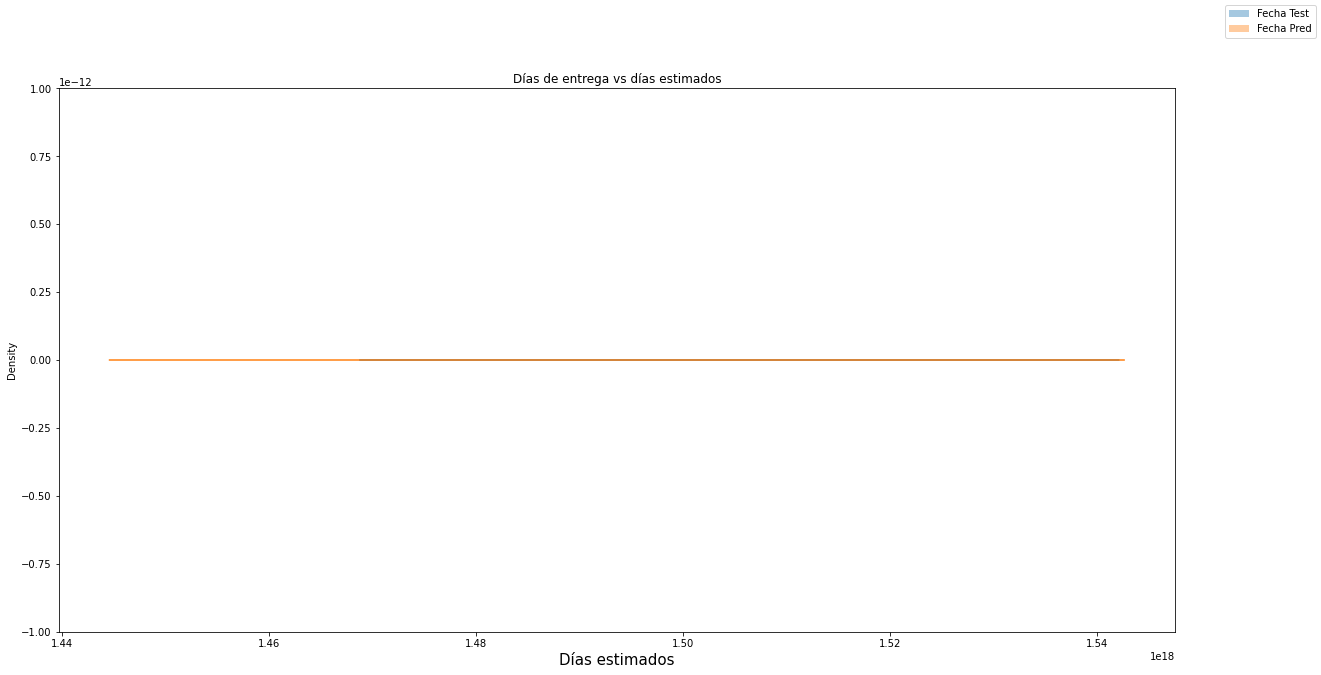

In [ ]:
fig = plt.figure(figsize=(20,10))

sns.distplot(df_concat['fecha_test'], kde=True, hist=True, bins=15, label='Fecha Test')
sns.distplot(df_concat['fecha_pred'], kde=True, hist=True, bins=15, label='Fecha Pred')
fig.legend()
plt.xlabel('Días estimados', fontsize = 15)
plt.title('Días de entrega vs días estimados')

plt.show()

En efecto observamos la regresión múltiple para la fecha de compra completa (X) y la fecha límite de envío completa (Y).

###Algoritmos de clasificación

#### ANÁLISIS RFM

Los clientes que compran en Olist tienen diferentes necesidades y tienen un perfil diferente. Debemos adaptar nuestras acciones en función de ello.

Para comenzar con la clasificación vamos a realizar un análisis RFM

RFM son las siglas de Recency - Frequency - Monetary Value. Teóricamente tendremos segmentos como los siguientes: 
**Churn customers:** clientes que pagan y que no se convierten en clientes habituales 

1.   **Churn customers:** clientes que pagan y que no se convierten en clientes habituales 
2.   **MID level customers:** utilizan a menudo la plataforma (pero no tanto como nuestros High Values), son bastante frecuentes y generan ingresos moderados.
3. **HIGH level customers:** El grupo que no queremos perder. Ingresos elevados, frecuencia y baja inactividad.

##### Recencia
---
Este indicador nos mostrará cuanto tiempo pasó desde la última fecha de compra hasta la fecha que tomemos como más reciente 
(para este caso lo ideal sería tomar la última fecha de compra de la que se tiene registro en el dataset)

In [ ]:
#Creamos un dataframe de usuario genérico para mantener el CustomerID
df_usuarios = pd.DataFrame(df['customer_unique_id'])
df_usuarios.columns = ['customer_unique_id']

#Obtenemos la fecha más reciente de compra de cada cliente y hacemos un DF
df_fecha_reciente = df.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
df_fecha_reciente.columns = ['customer_unique_id', 'Fecha + Reciente']

#Tomamos nuestro punto de partida como la fecha más reciente de compra y le restamos la de cada cliente.(En días)
df_fecha_reciente['Recencia'] = (df_fecha_reciente['Fecha + Reciente'].max() - df_fecha_reciente['Fecha + Reciente']).dt.days

#Unimos los dos DF creados
df_usuarios = pd.merge(df_usuarios, df_fecha_reciente[['customer_unique_id','Recencia']], on='customer_unique_id')

df_usuarios.head()

,customer_unique_id,Recencia
0,7c396fd4830fd04220f754e42b4e5bff,335
1,7c396fd4830fd04220f754e42b4e5bff,335
2,3a51803cc0d012c3b5dc8b7528cb05f7,383
3,ef0996a1a279c26e7ecbd737be23d235,396
4,e781fdcc107d13d865fc7698711cc572,314


In [ ]:
#Hacemos un describe del df obtenido
df_usuarios.describe()

,Recencia
count,96516.000000
mean,241.072351
std,152.971083
min,0.000000
25%,117.000000
50%,221.000000
75%,350.000000
max,728.000000


##### Fecuencia
---


Este indicador nos mostrará cuántas veces un cliente ha realizado una compra a lo largo del tiempo

In [ ]:
#Obtenemos los recuentos de pedidos de cada usuario y crear los guardamos en un dataframe
df_frecuencia = df.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
df_frecuencia.columns = ['customer_unique_id','Frecuencia']

#Lo añadimos al df principal
df_usuarios = pd.merge(df_usuarios, df_frecuencia, on='customer_unique_id')

In [ ]:
#Hacemos un describe del df obtenido
df_usuarios['Frecuencia'].describe()

count    96516.000000
mean         1.075366
std          0.370991
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
Name: Frecuencia, dtype: float64

##### Monetario
---

Este indicador de ingresos o también llamado "Monetary Value" nos muestra el valor de las compras totales que realizó un cliente a lo largo del tiempo

In [ ]:
#Calculamos el ingreso de cada cliente
df_ingresos = df.groupby('customer_unique_id').payment_value.sum().reset_index()

#Lo añadimos al df principal
df_usuarios = pd.merge(df_usuarios, df_ingresos, on='customer_unique_id')
df_usuarios = df_usuarios.rename(columns=	{'payment_value':'Monetario'})

In [ ]:
#Hacemos un describe del df obtenido
df_usuarios['Monetario'].describe()

count    96516.000000
mean       168.713717
std        232.194099
min          0.010000
25%         62.590000
50%        108.440000
75%        187.470000
max      13664.080000
Name: Monetario, dtype: float64

In [ ]:
##Df final obtenido
df_usuarios.head()

,customer_unique_id,Recencia,Frecuencia,Monetario
0,7c396fd4830fd04220f754e42b4e5bff,335,2,62.23
1,7c396fd4830fd04220f754e42b4e5bff,335,2,62.23
2,3a51803cc0d012c3b5dc8b7528cb05f7,383,1,37.77
3,ef0996a1a279c26e7ecbd737be23d235,396,1,37.77
4,e781fdcc107d13d865fc7698711cc572,314,1,44.09


### Creación de scores y clasificación
---

In [ ]:
#Buscamos cuartiles de las métricas obtenidas
quartiles=df_usuarios[['Recencia','Frecuencia','Monetario']].quantile(q=[0.25,0.50,0.75]) #Tomamos Q1,Q2,Q3
quartiles

,Recencia,Frecuencia,Monetario
0.25,117.0,1.0,62.59
0.50,221.0,1.0,108.44
0.75,350.0,1.0,187.47


In [ ]:
# Creamos las funciones de clasificación para los clientes
def r_score(x): # Calificación más reciente más alta y menos reciente más baja
    if x<=quartiles.loc[0.25,'Recencia']:
        return 4
    elif x<=quartiles.loc[0.50,'Recencia']:
        return 3
    elif x<=quartiles.loc[0.75,'Recencia']:
        return 2
    else:
        return 1

def f_score(x): #Calificación de los más frecuentes más alta y de los menos frecuentes más baja
    if x>= quartiles.loc[0.75,'Frecuencia']:
        return 4
    elif x>= quartiles.loc[0.50,'Frecuencia']:
        return 3
    elif x>= quartiles.loc[0.25,'Frecuencia']:
        return 2
    else:
        return 1
    
def m_score(x): #Calificación monetaria alta más alta y monetaria baja más baja
    if x>= quartiles.loc[0.75,'Monetario']:
        return 4
    elif x>=quartiles.loc[0.50,'Monetario']:
        return 3
    elif x>=quartiles.loc[0.25,'Monetario']:
        return 2
    else:
        return 1

In [ ]:
# Aplicamos las funciones para clasificar los clientes
df_usuarios['R_score']=df_usuarios['Recencia'].apply(r_score)
df_usuarios['F_score']=df_usuarios['Frecuencia'].apply(f_score)
df_usuarios['M_score']=df_usuarios['Monetario'].apply(m_score)
df_usuarios.head(3)

,customer_unique_id,Recencia,Frecuencia,Monetario,R_score,F_score,M_score
0,7c396fd4830fd04220f754e42b4e5bff,335,2,62.23,2,4,1
1,7c396fd4830fd04220f754e42b4e5bff,335,2,62.23,2,4,1
2,3a51803cc0d012c3b5dc8b7528cb05f7,383,1,37.77,1,4,1


In [ ]:
# Creamos la segmentación RFM
df_usuarios['Segmento RFM']=df_usuarios.R_score.astype(str)+df_usuarios.F_score.astype(str)+df_usuarios.M_score.astype(str)
df_usuarios.head(3)

,customer_unique_id,Recencia,Frecuencia,Monetario,R_score,F_score,M_score,Segmento RFM
0,7c396fd4830fd04220f754e42b4e5bff,335,2,62.23,2,4,1,241
1,7c396fd4830fd04220f754e42b4e5bff,335,2,62.23,2,4,1,241
2,3a51803cc0d012c3b5dc8b7528cb05f7,383,1,37.77,1,4,1,141


In [ ]:
#Añadimos un "Puntaje RFM" que es la sumatoria de todos los scores
df_usuarios['Puntaje RFM']=df_usuarios.R_score+df_usuarios.F_score+df_usuarios.M_score
df_usuarios.head(3)

,customer_unique_id,Recencia,Frecuencia,Monetario,R_score,F_score,M_score,Segmento RFM,Puntaje RFM
0,7c396fd4830fd04220f754e42b4e5bff,335,2,62.23,2,4,1,241,7
1,7c396fd4830fd04220f754e42b4e5bff,335,2,62.23,2,4,1,241,7
2,3a51803cc0d012c3b5dc8b7528cb05f7,383,1,37.77,1,4,1,141,6


In [ ]:
#Calculamos el promedio de Puntaje RFM
avg_rfm_score=df_usuarios['Puntaje RFM'].mean()
#Calculamos la mediana del Puntaje RFM
median_rfm_score=df_usuarios['Puntaje RFM'].median()
# Sumatoria de segmentos
print('Promedio del puntaje rfm para todos los clientes es: {}\n\nLa mediana del puntaje rfm para todos los clientes es: {}'\
     .format(round(avg_rfm_score,2),median_rfm_score))

Promedio del puntaje rfm para todos los clientes es: 9.0

La mediana del puntaje rfm para todos los clientes es: 9.0


In [ ]:
#Creamos la clasificación basada en el Puntaje RFM
df_usuarios['Clasificación']=0 #Creamos la columna de clasificación
df_usuarios.loc[(df_usuarios['Puntaje RFM']>=3) & (df_usuarios['Puntaje RFM']<=6),'Clasificación']='Churned customers'
df_usuarios.loc[(df_usuarios['Puntaje RFM']>=7) & (df_usuarios['Puntaje RFM']<=8),'Clasificación']='MID level customers'
df_usuarios.loc[(df_usuarios['Puntaje RFM']>=9) & (df_usuarios['Puntaje RFM']<=12),'Clasificación']='HIGH level customers'

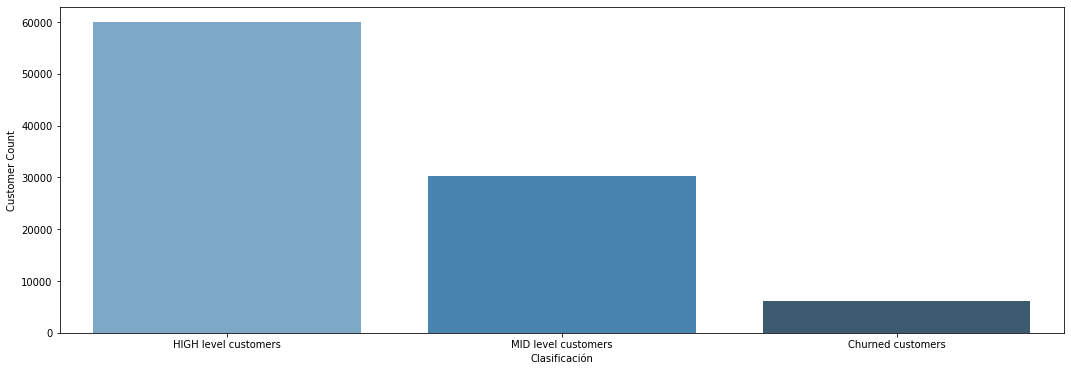

In [ ]:
#Visualizamos la segmentación de clientes
plt.figure(figsize=(18,6))
sns.countplot(x='Clasificación',data=df_usuarios,palette="Blues_d",\
            order=['HIGH level customers','MID level customers','Churned customers'])
plt.ylabel('Customer Count')
plt.show()

## K-NN

En este modelo, se basa en las observaciones o "vecinos" más cercanas a la que se está tratando de predecir y clasifica el punto de interés basado en la mayoría de datos que lo rodean.

In [ ]:
#Creamos nuestro "X" e "y" de entrada y los sets de entrenamiento y prueba
X = df_usuarios[['Frecuencia','Recencia','Monetario']].values
#Definimos la variable objetivo
y = df_usuarios['Clasificación'].values
#Separamos el data set 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#Entrenamos el algoritmo
knn = KNeighborsClassifier(100)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=100)

In [ ]:
#Veamos la matriz de confusión y el reporte de clasificación
pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[ 1458     2    73]
 [    0 14711   330]
 [   99   100  7356]]
                      precision    recall  f1-score   support

   Churned customers       0.94      0.95      0.94      1533
HIGH level customers       0.99      0.98      0.99     15041
 MID level customers       0.95      0.97      0.96      7555

            accuracy                           0.97     24129
           macro avg       0.96      0.97      0.96     24129
        weighted avg       0.98      0.97      0.98     24129



[[ 1458     2    73]
 [    0 14711   330]
 [   99   100  7356]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


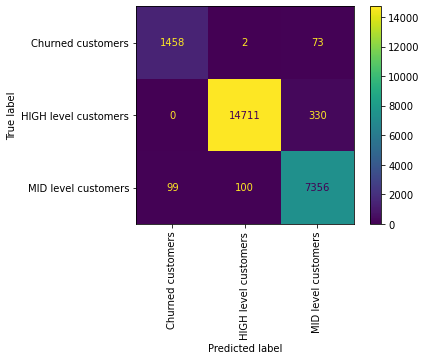

In [ ]:
#Matriz de Confusión
print(confusion_matrix(y_test, pred))

#Ploteamos la Matriz
plot_confusion_matrix(knn, X_test, y_test,xticks_rotation='vertical')
plt.show()

## Mejora de modelos de clasificación

Hyperparameter Tuning GRIDSEARCH


                      precision    recall  f1-score   support

   Churned customers       0.97      0.98      0.98      1533
HIGH level customers       1.00      1.00      1.00     15041
 MID level customers       0.99      0.99      0.99      7555

            accuracy                           0.99     24129
           macro avg       0.99      0.99      0.99     24129
        weighted avg       0.99      0.99      0.99     24129

[[ 1507     0    26]
 [    0 14977    64]
 [   41    28  7486]]
{'metric': 'euclidean', 'weights': 'distance'}


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


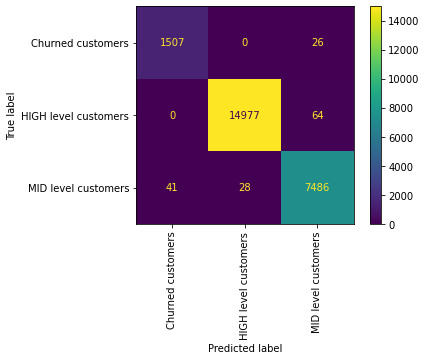

In [ ]:
knn_params = {
    'weights': ['uniform','distance'],
    'metric': ['euclidean','manhattan','minkowski'],
    # 'algorithm': ['auto','ball_tree','kd_tree','brute']
} 

#grid search
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=42)
grid_search = GridSearchCV(estimator=knn, param_grid=knn_params, n_jobs=1,cv=cv,scoring='accuracy',error_score=0)
grid_results = grid_search.fit(X_train, y_train)

#best model
final_model = knn.set_params(**grid_results.best_params_)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

#summatoria de resultados
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print(grid_results.best_params_)
plot_confusion_matrix(knn, X_test, y_test,xticks_rotation='vertical')